## POS Tagger

In [1]:
import re
import string
import pandas as pd
from collections import Counter
from hazm import sent_tokenize, word_tokenize, Normalizer, POSTagger

In [2]:
comments_df = pd.read_csv(r'Datasets\digikala_comment.csv')
comments_df.head()

,comment
0,نسبت به قیمتش ارزش خرید داره\nجاداره، طراحیش ق...
1,چند ماهی میشه که گرفتمش‌. برای برنامه نویسی و ...
2,پراید ستون جدید
3,اقا همه چیش خوبه فقط از پایین زیاد حاشیه داره ...
4,گوسی هو اوی p10 lite سیپیو و دوربین و رمش از ا...


## Pre-Process

In [3]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def preprocess_sentences(comments_df):
    # Convert comments into sentences
    normalizer = Normalizer()
    comments_df['sentences'] = comments_df['comment'].apply(lambda comment: sent_tokenize(comment))
    comments_df.drop('comment', axis=1, inplace=True)

    # Convert DataFrame into a list of sentences
    sentences_list = comments_df['sentences'].tolist()
    flat_sentences_list = [sentence for sublist in sentences_list for sentence in sublist]

    normalized_sentences = [normalizer.normalize(s) for s in flat_sentences_list]

    # Remove Zero-Width Non-Joiners
    sentences = [sentence.replace('\u200c', ' ') for sentence in normalized_sentences]

    # Remove English characters from sentences
    cleaned_sentences = []
    english_pattern = re.compile(r'[a-zA-Z]')
    for sentence in sentences:
        cleaned_sentence = ' '.join(word for word in word_tokenize(sentence) if not english_pattern.search(word))
        cleaned_sentences.append(cleaned_sentence)

    # Remove punctuations from sentences
    punctuations = string.punctuation + '،' + '؟'
    cleaned_sentences_no_punc = []
    for sentence in cleaned_sentences:
        cleaned_sentence = ''.join(char for char in sentence if char not in punctuations)
        cleaned_sentences_no_punc.append(cleaned_sentence)

    # Remove stop words (Top unigrams are stop words) - stop_words() from hazm reduces ability to predict, only top stop words are removed
    # stopwords = stopwords_list()
    stopwords = ['و', 'از', 'این', 'که', 'به', 'هم', 'خیلی', 'رو', 'با', 'در', 'برای']
    cleaned_sentences_no_stopwords = []
    for sentence in cleaned_sentences_no_punc:
        cleaned_sentence = ' '.join(word for word in word_tokenize(sentence) if word not in stopwords)
        cleaned_sentences_no_stopwords.append(cleaned_sentence)

    # Remove emojis
    cleaned_sentences_no_emojis = [remove_emoji(sentence) for sentence in cleaned_sentences_no_stopwords]

    return cleaned_sentences_no_emojis

In [4]:
c = preprocess_sentences(comments_df)

In [5]:
print('Number of sententences:', len(c))
for i in range(10):
    print(c[i])

Number of sententences: 463
نسبت قیمتش ارزش خرید داره جاداره طراحیش قشنگه تنها مشکلش بندهای ضعیفش هست باعث میشه استحکام چندانی نداشنه باشه
چند ماهی میشه گرفتمش
برنامه نویسی کارای گرافیکی ازش استفاده می کنم
واقعا هر لحاظ بگین عالیه
پراید ستون جدید
اقا همه چیش خوبه فقط پایین زیاد حاشیه داره روشن شدن گوشی بیشتر میشه
نکته دیگه اینکه خاطر اطرافش یه کوچلو خمیده هست گلس بعد یه مدتی جدا مشیه
ولی کل قیمت بهترین گوشی هست همه چی داره دوربین گرفته تا رم سی پی یو گرافیک حسگر های مختلف چیزای دیگه
گوسی هو اوی ۱۰ سیپیو دوربین رمش بهتره خودتون میتونین برین تمام مقایسه های ۱۰ گوشیو ببینین
چادر سبک زیباییه دوختشم عالیه


## POS Tagging

In [6]:
def pos_tag_sentences(sentences):
    tagger = POSTagger(model='Resources/pos_tagger.model')
    pos_tagged_sentences = []
    
    for sentence in sentences:
        words = word_tokenize(sentence)
        tagged_words = tagger.tag(words)
        pos_tagged_sentences.append(tagged_words)
    
    return pos_tagged_sentences

In [7]:
pos_tagged_sentences = pos_tag_sentences(c)

# POS Tagging results for 1st sentence
for token, pos_tag in pos_tagged_sentences[0]:
    print(f"{token} -> {pos_tag}")

نسبت -> NOUN,EZ
قیمتش -> NOUN
ارزش -> NOUN,EZ
خرید -> NOUN
داره -> VERB
جاداره -> NOUN,EZ
طراحیش -> NOUN
قشنگه -> VERB
تنها -> ADV
مشکلش -> NOUN
بندهای -> NOUN,EZ
ضعیفش -> ADJ
هست -> VERB
باعث -> ADJ,EZ
میشه -> NOUN
استحکام -> NOUN,EZ
چندانی -> ADJ
نداشنه -> VERB
باشه -> VERB


## Tag Counts

In [8]:
all_pos_tags = [tag for sentence in pos_tagged_sentences for _, tag in sentence]

pos_tag_counts = Counter(all_pos_tags)

print("POS Tag Counts:")
for tag, count in pos_tag_counts.items():
    print(f"{tag}: {count}")

POS Tag Counts:
NOUN,EZ: 1505
NOUN: 2048
VERB: 1310
ADV: 449
ADJ: 669
ADJ,EZ: 259
DET: 100
ADP: 147
DET,EZ: 23
PRON: 218
CCONJ: 171
NUM: 332
SCONJ: 109
PUNCT: 30
ADV,EZ: 22
ADP,EZ: 108
NUM,EZ: 5
INTJ: 30
PRON,EZ: 6


## Visual Report

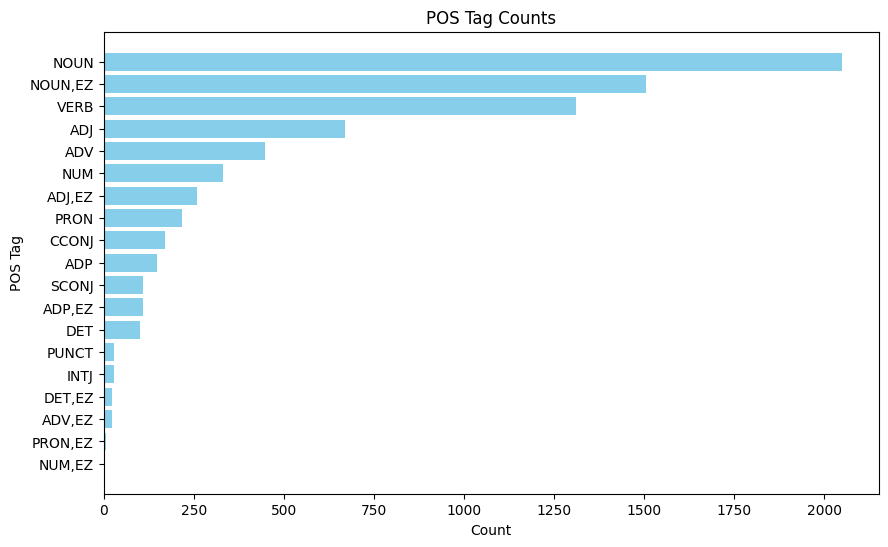

In [9]:
import matplotlib.pyplot as plt

tags = list(pos_tag_counts.keys())
counts = list(pos_tag_counts.values())
sorted_tags, sorted_counts = zip(*sorted(zip(tags, counts), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.barh(sorted_tags, sorted_counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('POS Tag')
plt.title('POS Tag Counts')
plt.gca().invert_yaxis()
plt.show()


## Top 15 Nouns

In [10]:
def extract_and_report_nouns(tagged_sentences, count=15):
    nouns = []
    for sentence in tagged_sentences:
        for word, tag in sentence:
            if tag == 'NOUN' or tag == 'NOUN,EZ':
                nouns.append(word)

    noun_counts = Counter(nouns)

    top_nouns = []
    top_counts = []
    for noun, count in noun_counts.most_common(count):
        top_nouns.append(noun)
        top_counts.append(count)

    return top_nouns, top_counts


In [11]:
top_nouns, top_counts = extract_and_report_nouns(pos_tagged_sentences)
print("Top 15 Most Repeated Nouns:")
for noun, count in zip(top_nouns, top_counts):
    print(f"{noun}: {count}")

Top 15 Most Repeated Nouns:
می: 98
گوشی: 72
کیفیت: 51
های: 49
استفاده: 41
ها: 34
قیمت: 33
نسبت: 27
نظر: 27
خرید: 25
میشه: 23
پیشنهاد: 23
دستگاه: 23
مدل: 21
صدا: 20


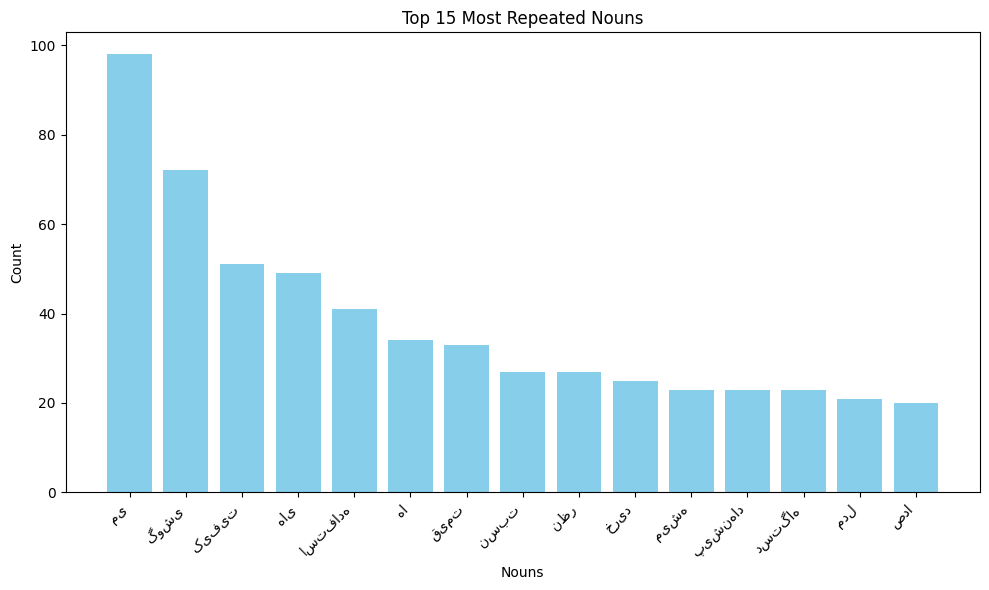

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(top_nouns, top_counts, color='skyblue')
plt.xlabel('Nouns')
plt.ylabel('Count')
plt.title('Top 15 Most Repeated Nouns')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()